In [ ]:
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR
from sklearn.preprocessing import StandardScaler

import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

from numpy.linalg import cond

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Processing incidents data

Aggregate the incidents data into grids with side lengths of 500m and calculate the centroid of each grid. Calculate the response time of each event. The definition of response time here is reaction seconds plus driving seconds according to the requirements.

In [ ]:
incidents = pd.read_csv('Data/WMFS_datasets/wmfs_incidents.csv')
# Only pay attention to incidents of type 'FIRE' and 'FALSE_ALARM'
incidents = incidents[incidents['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]
incidents = incidents.reset_index(drop=True)

In [ ]:
### Aggregate the data into grids
# Define the grid size
grid_size = 500

# Calculate the bound
xmin = incidents['EASTINGS'].min() // grid_size * grid_size # // means quotient rounding
xmax = incidents['EASTINGS'].max() // grid_size * grid_size + grid_size # rounding down so another grid needs to be added
ymin = incidents['NORTHINGS'].min() // grid_size * grid_size
ymax = incidents['NORTHINGS'].max() // grid_size * grid_size + grid_size
# Caculate the grid index
incidents['grid_x'] = ((incidents['EASTINGS'] - xmin) // grid_size).astype(int)
incidents['grid_y'] = ((incidents['NORTHINGS'] - ymin) // grid_size).astype(int)

# Add a grid_id to each incident and fire station
incidents['grid_id'] = incidents['grid_x'].astype(str) + "_" + incidents['grid_y'].astype(str)

In [ ]:
### Caculate the centroid of each grid
incidents['centroid_x'] = xmin + (incidents['grid_x'] + 0.5) * grid_size
incidents['centroid_y'] = ymin + (incidents['grid_y'] + 0.5) * grid_size

# Extract the centroid coordinates into a new dataframe to facilitate merging later
grid_centroids = incidents[['grid_id', 'centroid_x', 'centroid_y']].drop_duplicates().reset_index(drop=True)
grid_centroids

,grid_id,centroid_x,centroid_y
0,12_29,392250.0,286750.0
1,39_11,405750.0,277750.0
2,48_33,410250.0,288750.0
3,21_54,396750.0,299250.0
4,49_36,410750.0,290250.0
...,...,...,...
3729,79_22,425750.0,283250.0
3730,68_8,420250.0,276250.0
3731,2_32,387250.0,288250.0
3732,69_9,420750.0,276750.0


In [ ]:
# Define 'total response time'
incidents['total_response_time'] = incidents['reaction_seconds'] + incidents['driving_seconds']
incidents

,call_time,incident_classification_label,incident_profile_label,incident_classification_level1,prl_count,brv_count,EASTINGS,NORTHINGS,call_seconds,reaction_seconds,driving_seconds,grid_x,grid_y,grid_id,centroid_x,centroid_y,total_response_time
0,2009/1/1 0:00,False alarm raised with good intent,False Alarms,FALSE_ALARM,2,0,392062.1020,286844.9690,86,160,250,12,29,12_29,392250.0,286750.0,410
1,2009/1/1 0:10,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,405643.1494,277939.9802,85,65,239,39,11,39_11,405750.0,277750.0,304
2,2009/1/1 0:11,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410260.2444,288819.1894,62,106,115,48,33,48_33,410250.0,288750.0,221
3,2009/1/1 0:53,Secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,1,0,396779.2503,299030.1061,72,109,96,21,54,21_54,396750.0,299250.0,205
4,2009/1/1 0:52,False alarm raised with malicious intent,False Alarms,FALSE_ALARM,1,0,410667.9614,290492.4786,68,109,204,49,36,49_36,410750.0,290250.0,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292692,2023/12/31 22:59,False Alarms (Equipment),Low Risk,FALSE_ALARM,2,0,398666.6867,283225.4570,88,82,281,25,22,25_22,398750.0,283250.0,363
292693,2023/12/31 23:11,False alarm raised with good intent,False Alarms,FALSE_ALARM,1,1,433136.8678,277909.0307,134,94,98,94,11,94_11,433250.0,277750.0,192
292694,2023/12/31 23:32,Accidental secondary fire,Secondary Fires that attract a 20 minute-respo...,FIRE,0,1,401134.3304,277356.6820,136,152,227,30,10,30_10,401250.0,277250.0,379
292695,2023/12/31 23:49,False Alarms (Equipment),Low Risk,FALSE_ALARM,0,1,406221.0587,290654.1816,253,66,297,40,37,40_37,406250.0,290750.0,363


Then, calculate the proportion of delayed fires in each grid as the independent variable. The definition of delayed fire here is the historical incients with total response time greater than 300s.

In [ ]:
grouped = incidents.groupby('grid_id')

# Create a list for each unique grid id
distribution = []

for name, group in grouped:
    # Count the fire incidents in each grid
    count = group.shape[0]

    # Calculate the count of incidents whose total_response_time > 300
    count_over_300 = group[group['total_response_time'] > 300].shape[0]

    # Calculate the proportion
    proportion_over_300 = count_over_300 / count if count > 0 else 0

    distribution.append([name, count, count_over_300, proportion_over_300])

grid = pd.DataFrame(distribution, columns=['grid_id','fire_count', 'count_over_300', 'proportion_over_300'])
grid

,grid_id,fire_count,count_over_300,proportion_over_300
0,0_51,1,1,1.000000
1,0_52,10,10,1.000000
2,0_53,4,4,1.000000
3,100_10,131,99,0.755725
4,100_11,103,48,0.466019
...,...,...,...,...
3729,9_59,27,27,1.000000
3730,9_60,42,37,0.880952
3731,9_61,63,60,0.952381
3732,9_62,59,55,0.932203


### 2. Processing the dependent variable and independent variables

First, isolate all independent variables (X) and the dependent variable (y) to be used.

In [ ]:
# Load the feature data of grids and merge it with centroid coordinates
dataset = pd.read_csv('Data/dataset_no_land.csv')
dataset_coord = pd.merge(dataset, grid_centroids, on='grid_id', how='left')

In [ ]:
# Load the land cover data and merge it with previous dataset
land_corine_1 = pd.read_csv('Data/land_cover/results/land_corine_1.csv') # corine land cover 1 2018

dataset_corine_1 = pd.merge(dataset_coord, land_corine_1, on='grid_id', how='left')

In [ ]:
# Merge the dependent variable and independent variables
final_dataset = pd.merge(grid[['grid_id', 'proportion_over_300']], dataset_corine_1.drop(columns=['median', 'percentile_90']), on='grid_id', how='left')

In [ ]:
final_dataset

,grid_id,proportion_over_300,"Accommodation, eating and drinking",Attractions,Commercial services,Education and health,Manufacturing and production,Public infrastructure,Retail,Sport and entertainment,...,road_length,nearest_station_distance,neighbour_frequency_per_month,station_count,centroid_x,centroid_y,Agricultural areas,Artificial surfaces,Forest and semi natural areas,Water bodies
0,0_51,1.000000,0,0,0,0,0,0,0,0,...,353.287313,3187.918600,0.177778,5,386250.0,297750.0,100.000000,0.000000,0.0,0.0
1,0_52,1.000000,0,0,0,1,0,1,0,1,...,1328.092389,2841.271722,0.194444,5,386250.0,298250.0,68.929306,31.070694,0.0,0.0
2,0_53,1.000000,0,1,0,1,1,1,0,0,...,768.983971,2546.139234,0.188889,5,386250.0,298750.0,56.548633,43.451367,0.0,0.0
3,100_10,0.755725,0,2,1,2,0,4,0,2,...,734.304719,1571.100570,5.922222,4,436250.0,277250.0,94.937310,5.062690,0.0,0.0
4,100_11,0.466019,0,1,3,0,0,1,0,1,...,2987.218972,1130.202194,3.855556,4,436250.0,277750.0,47.371040,52.628960,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,9_59,1.000000,0,0,2,1,1,1,1,0,...,2006.875970,2561.426360,1.627778,6,390750.0,301750.0,0.000000,100.000000,0.0,0.0
3730,9_60,0.880952,0,0,13,2,2,3,2,1,...,2732.349447,2808.541436,2.211111,6,390750.0,302250.0,0.000000,100.000000,0.0,0.0
3731,9_61,0.952381,0,1,1,1,0,5,0,1,...,1543.196315,3116.874236,2.677778,6,390750.0,302750.0,0.000000,100.000000,0.0,0.0
3732,9_62,0.932203,3,1,4,0,0,5,1,3,...,2025.332899,3470.144810,2.005556,6,390750.0,303250.0,0.000000,100.000000,0.0,0.0


In [ ]:
# Separate dependent and independt variables
X = final_dataset.drop(columns=['grid_id', 'proportion_over_300', 'centroid_x', 'centroid_y'])
y_delay = final_dataset['proportion_over_300']

#### Interpolation using similar grids

For grids with only 1, 2, and 3 historical data, their proportion of delyed fires data will make the model inaccurate. Use data from grids similar to them to interpolate.

In [ ]:
# Drop the grids with incidents less than or equal to 3
grid_drop = grid[(grid['fire_count'] == 1) | (grid['fire_count'] == 2) | (grid['fire_count'] == 3)]
grid_drop_df = final_dataset[final_dataset['grid_id'].isin(grid_drop['grid_id'])]

In [ ]:
# Caculate cosine similarity to find similar grids
def calculate_cosine_similarity(target_grid, all_grids, features_columns):
    target_vector = [target_grid[features_columns].values]
    all_vectors = all_grids[features_columns].values
    similarities = cosine_similarity(target_vector, all_vectors)
    return similarities.flatten()

In [ ]:
# Interpolation
def interpolate_proportion(target_grid, similar_grids, num_similar=3):

    similar_grids_sorted = similar_grids.sort_values('similarity', ascending=False).head(num_similar)

    # Combine the original with the values of the similar grids
    combined_proportion = np.append(similar_grids_sorted['proportion_over_300'], target_grid['proportion_over_300'])

    # Calculate the average value
    average_proportion = combined_proportion.mean()

    return average_proportion

In [ ]:
# Apply to grid_drop_df
def process_grid_interpolation(final_dataset, grid_drop_df, features_columns, num_similar=3):

    y_delay = final_dataset['proportion_over_300'].copy()

    for index, row in grid_drop_df.iterrows():

        similarities = calculate_cosine_similarity(row, final_dataset, features_columns)
        similar_grids = y_delay.copy()
        similar_grids = similar_grids.to_frame()

        similar_grids['similarity'] = similarities

        # Exclude the current grid itself
        similar_grids = similar_grids[similar_grids.index != index]

        # Exclude other grids with no sufficient data
        similar_grids = similar_grids.drop(grid_drop_df.index, errors='ignore')

        new_delay_proportion = interpolate_proportion(row, similar_grids, num_similar=num_similar)

        # Update y
        y_delay.at[index] = new_delay_proportion

    return y_delay

In [ ]:
features_columns = X.columns.tolist()
y_delay = process_grid_interpolation(final_dataset, grid_drop_df, features_columns)

In [ ]:
# Check how many grid's proportion of delayed fires values ​​changed due to interpolation
final_dataset_sorted = final_dataset.sort_index()
y_delay_sorted = y_delay.sort_index()

comparison = final_dataset_sorted['proportion_over_300'] != y_delay_sorted

comparison.sum()

195

### 3. Modelling

First, use random forest to select the 10 most important features. And then standardize the feature data to prevent matrix singularities and perform geographically weighted regression.

#### Using Random Forest to select important featrures

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_delay, test_size=0.2, random_state=0)

# Select the features using random forest
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

selector = SelectFromModel(rf, threshold='median')
selector.fit(X_train, y_train)

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

In [ ]:
# The value of feature importance
feature_importances = rf.feature_importances_
selected_features_mask = selector.get_support()

# Get the feature importance
selected_feature_importances = feature_importances[selected_features_mask]

selected_feature_indices = np.where(selected_features_mask)[0]
selected_feature_names = np.array(X.columns)[selected_feature_indices]

sorted_indices = np.argsort(selected_feature_importances)[::-1]

# Select the 10 most important features
top_10_features = selected_feature_names[sorted_indices][:10]
top_10_df = final_dataset[list(top_10_features)]

#### Geographically Weighted Regression

Here we use adaptive bandwidth, which means that the searched bandwidth number represents how many surrounding points (including itself) are selected for regression.

In [ ]:
coords = dataset_coord[['centroid_x', 'centroid_y']].values

In [ ]:
scaler = StandardScaler()
X_mgwr = top_10_df.values
X_mgwr_scaled = scaler.fit_transform(X_mgwr)

y_mgwr = y_delay.values.reshape(-1, 1)

In [ ]:
# Choose the optimal bandwidth
gwr_selector = Sel_BW(coords, y_mgwr, X_mgwr_scaled)
optimal_bandwidth = gwr_selector.search()

LinAlgError: Matrix is singular.


The matrix was found to be singular, so we tried to add a small perturbation with a mean of 0 and a standard deviation of 10^(-6) to solve the singular problem by reducing the feature collinearity.

In [ ]:
epsilon = 1e-6
np.random.seed(0)
X_mgwr_scaled_noisy = X_mgwr_scaled + np.random.normal(0, epsilon, X_mgwr_scaled.shape)


In [ ]:
# Choose the optimal bandwidth
gwr_selector_small = Sel_BW(coords, y_mgwr, X_mgwr_scaled_noisy)
optimal_bandwidth_small = gwr_selector_small.search()

In [ ]:
optimal_bandwidth_small

117.0

In [ ]:
gwr_model_small = GWR(coords, y_mgwr, X_mgwr_scaled_noisy, optimal_bandwidth_small)
gwr_results_small = gwr_model_small.fit()

In [ ]:
print(f"R² with bandwidth {optimal_bandwidth_small}: {gwr_results_small.R2}")

local_coefficients_small = gwr_results_small.params
average_coefficients_small = np.mean(local_coefficients_small, axis=0)
print("mean coefficient of each x variable:", average_coefficients_small)

R² with bandwidth 117.0: 0.8848419409626318
mean coefficient of each x variable: [-2.50100750e+02  2.63559081e-01 -4.39250053e-02 -1.84005737e-03
 -2.17876440e+02 -1.42971695e-02 -3.91917252e-03  1.18569372e-02
 -1.91326029e-02 -1.15064569e-03  1.46079994e-02]


It is found that the coefficient of intercept and x4 is particularly large, try to increase the bandwidth to obtain a more stable model. And then visualize the x4 characteristic coefficient distribution of small bandwidth. We set the lower limit of bandwidth search to 380.

In [ ]:
# Choose the optimal bandwidth
gwr_selector_large = Sel_BW(coords, y_mgwr, X_mgwr_scaled_noisy)
optimal_bandwidth_large = gwr_selector_large.search(bw_min = 380)

In [ ]:
optimal_bandwidth_large

382.0

In [ ]:
gwr_model_large = GWR(coords, y_mgwr, X_mgwr_scaled_noisy, optimal_bandwidth_large)
gwr_results_large = gwr_model_large.fit()

In [ ]:
print(f"R² with bandwidth {optimal_bandwidth_large}: {gwr_results_large.R2}")

local_coefficients_large = gwr_results_large.params
average_coefficients_large = np.mean(local_coefficients_large, axis=0)
print("mean coefficient of each x variable:", average_coefficients_large)

R² with bandwidth 382.0: 0.8072784873644645
mean coefficient of each x variable: [ 6.86194742e-01  2.51826250e-01 -6.20847568e-02  5.10133288e-04
 -5.52980907e-02 -2.15822760e-03  7.75946775e-03  1.13314874e-02
 -2.27903555e-02 -1.89827333e-04  9.34501916e-03]


### 4. Plotting

Extract the R square, the features x1, x2 and x4 in the regression results of small bandwidth and large bandwidth respectively, and create a geodataframe. Geometry is the square of the grid where the centroid is located.

In [ ]:
local_r2 = gwr_results.localR2

# Create a geodataframe consisting of local R-squared, local coefficients of X1 and X2
data = pd.DataFrame({
    "X1_coeff": local_coefficients[:, 1], # coefficients of distance to the nearest fire station
    "X2_coeff": local_coefficients[:, 2], # coefficients of neighbourhood fire frequency
    "X4_coeff": local_coefficients[:, 4],
    "centroid_x": coords[:, 0],
    "centroid_y": coords[:, 1],
    "R2_local": local_r2.flatten()
})

In [ ]:
# Create the geometry column as Point objects
data['geometry'] = data.apply(lambda row: Point(row['centroid_x'], row['centroid_y']), axis=1)
gdf = gpd.GeoDataFrame(data, geometry='geometry', crs="EPSG:27700")

# Function to convert centroids to square polygons
def centroid_to_square(centroid, side_length=500):
    x, y = centroid.x, centroid.y
    half_side = side_length / 2
    return Polygon([
        (x - half_side, y - half_side),
        (x + half_side, y - half_side),
        (x + half_side, y + half_side),
        (x - half_side, y + half_side),
    ])

# Convert centroid points to square polygons
gdf['geometry'] = gdf['geometry'].apply(centroid_to_square)

In [ ]:
# Function to process GWR results and create a GeoDataFrame
def process_gwr_results(gwr_results, local_coefficients, coords, crs="EPSG:27700", side_length=500):
    # Extract local R² values
    local_r2 = gwr_results.localR2

    # Create a DataFrame with coefficients and coordinates
    data = pd.DataFrame({
        "X1_coeff": local_coefficients[:, 1],  # coefficients of distance to the nearest fire station
        "X2_coeff": local_coefficients[:, 2],  # coefficients of neighbourhood fire frequency
        "X4_coeff": local_coefficients[:, 4],  # coefficients of station count within a specific distance
        "centroid_x": coords[:, 0],
        "centroid_y": coords[:, 1],
        "R2_local": local_r2.flatten()
    })

    # Create the geometry column as Point objects
    data['geometry'] = data.apply(lambda row: Point(row['centroid_x'], row['centroid_y']), axis=1)
    gdf = gpd.GeoDataFrame(data, geometry='geometry', crs=crs)

    # Function to convert centroids to square polygons
    def centroid_to_square(centroid, side_length=side_length):
        x, y = centroid.x, centroid.y
        half_side = side_length / 2
        return Polygon([
            (x - half_side, y - half_side),
            (x + half_side, y - half_side),
            (x + half_side, y + half_side),
            (x - half_side, y + half_side),
        ])

    # Convert centroid points to square polygons
    gdf['geometry'] = gdf['geometry'].apply(centroid_to_square)

    return gdf

In [ ]:
# Process both small and large GWR results
gdf_small = process_gwr_results(gwr_results_small, local_coefficients_small, coords)
gdf_large = process_gwr_results(gwr_results_large, local_coefficients_large, coords)


### Small Bandwidth

#### Image of local R-squared

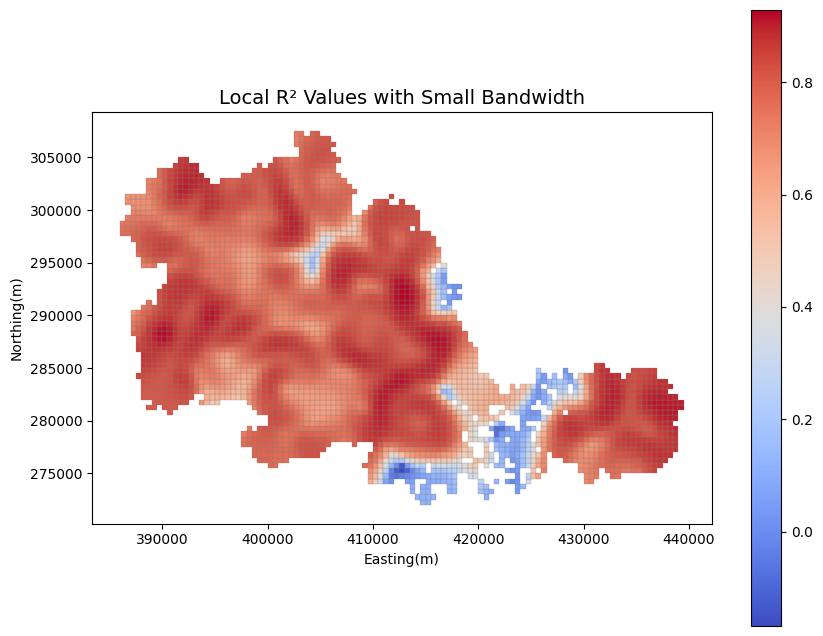

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_small.plot(column='R2_local', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)

ax.set_title("Local R² Values with Small Bandwidth", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

#### Image of local coefficients

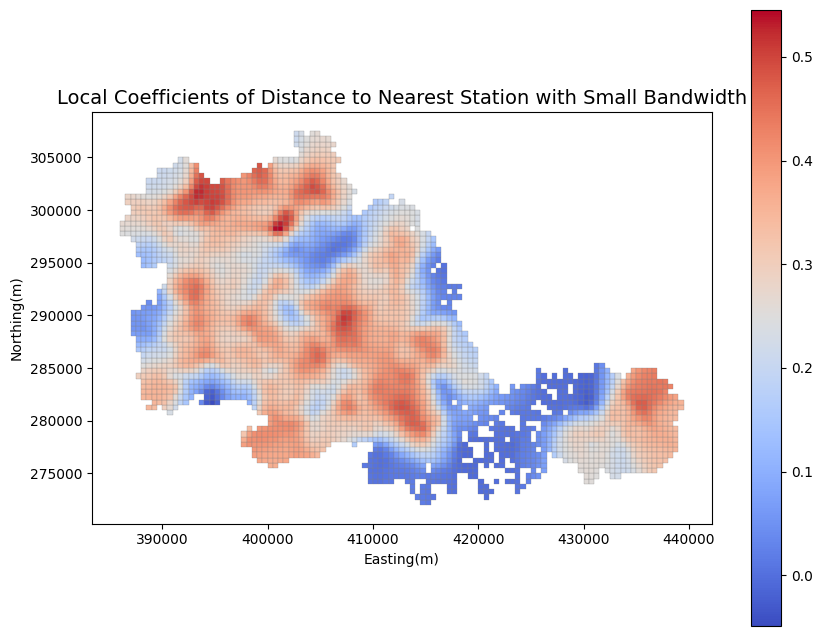

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_small.plot(column='X1_coeff', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
ax.set_title("Local Coefficients of Distance to Nearest Station with Small Bandwidth", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

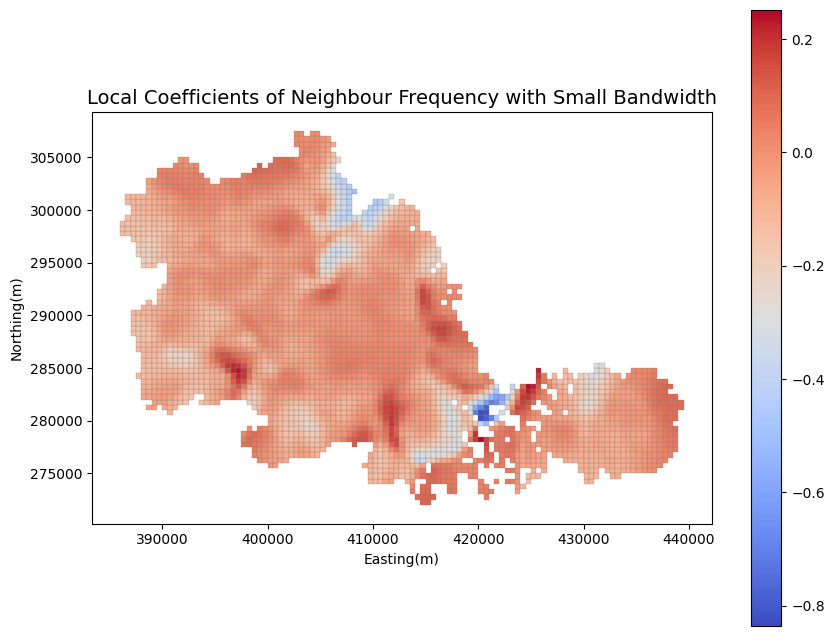

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_small.plot(column='X2_coeff', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
ax.set_title("Local Coefficients of Neighbour Frequency with Small Bandwidth", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

In [ ]:
threshold = 0
gdf_small[gdf_small['X2_coeff'] > threshold].index

Index([  10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
       ...
       3679, 3680, 3681, 3682, 3704, 3729, 3730, 3731, 3732, 3733],
      dtype='int64', length=1252)

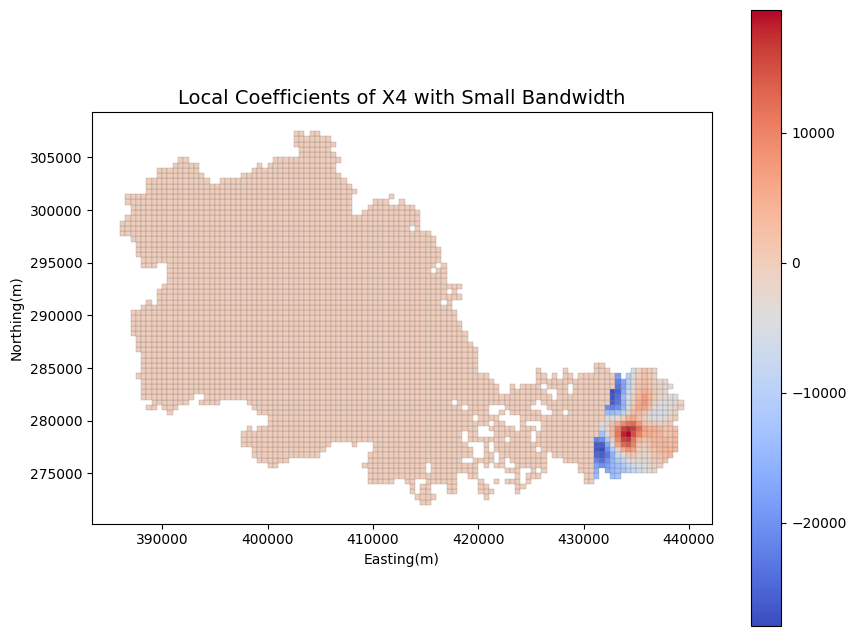

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_small.plot(column='X4_coeff', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
ax.set_title("Local Coefficients of X4 with Small Bandwidth", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

### Large Bandwidth

#### Image of local R-squared

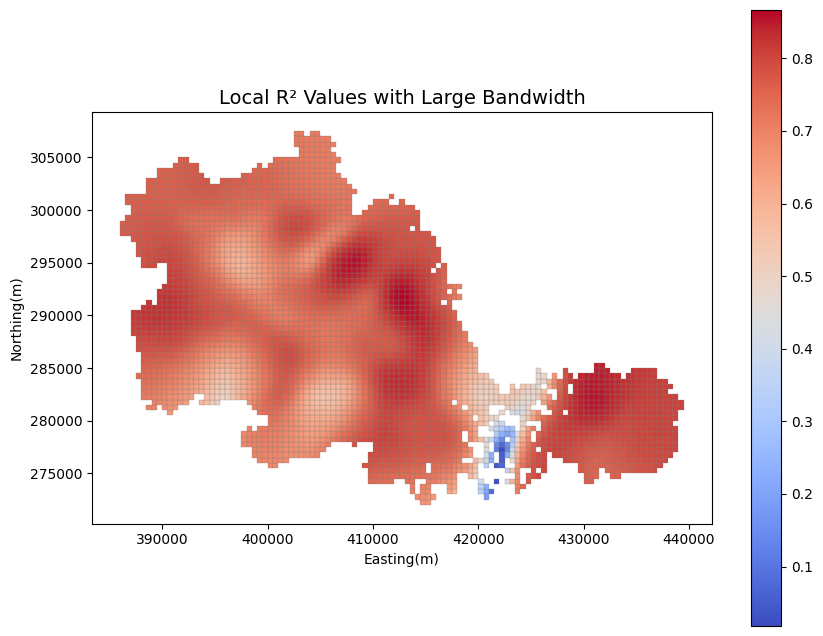

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_large.plot(column='R2_local', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)

ax.set_title("Local R² Values with Large Bandwidth", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

#### Image of local coefficients

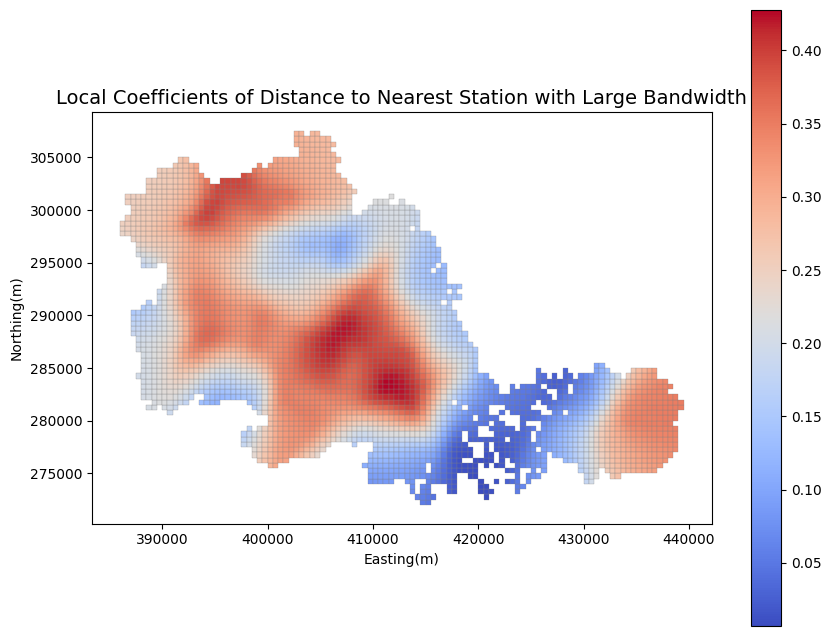

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_large.plot(column='X1_coeff', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
ax.set_title("Local Coefficients of Distance to Nearest Station with Large Bandwidth", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

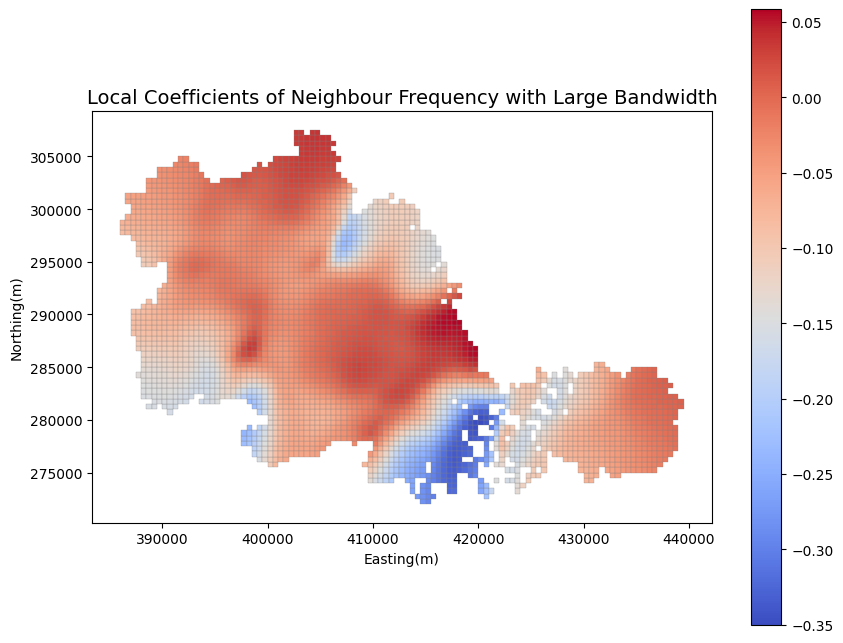

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_large.plot(column='X2_coeff', cmap='coolwarm', legend=True, ax=ax, edgecolor='grey', linewidth=0.2)
ax.set_title("Local Coefficients of Neighbour Frequency with Large Bandwidth", fontsize=14)
plt.xlabel("Easting(m)")
plt.ylabel("Northing(m)")

plt.show()

In [ ]:
threshold = 0
gdf_large[gdf_large['X2_coeff'] > threshold].index

Index([  13,   14,   15,   16,   17,   18,   32,   33,   34,   35,
       ...
       3000, 3001, 3002, 3019, 3020, 3021, 3022, 3023, 3679, 3680],
      dtype='int64', length=754)

### 5. Condition Number Comparison

In [ ]:
# Calculate the local condition number for each point
small_conditions = []
large_conditions = []

for i in range(coords.shape[0]):
    # Extract local weights for the current point
    small_weights = gwr_results_small.W[i]
    large_weights = gwr_results_large.W[i]

    # Compute the locally weighted feature matrix
    small_local_X = X_mgwr_scaled_noisy * small_weights[:, np.newaxis]
    large_local_X = X_mgwr_scaled_noisy * large_weights[:, np.newaxis]

    try:
        # Calculate the condition number for the local matrix
        small_conditions.append(cond(small_local_X))
        large_conditions.append(cond(large_local_X))
    except Exception:
        small_conditions.append(float('inf'))
        large_conditions.append(float('inf'))

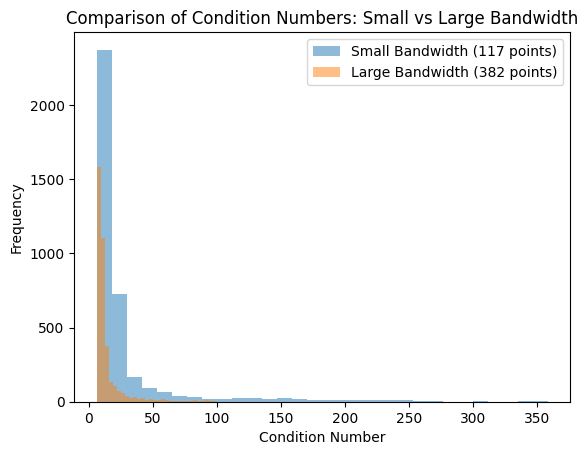

In [ ]:
plt.hist(small_conditions, bins=30, alpha=0.5, label='Small Bandwidth (117 points)')
plt.hist(large_conditions, bins=30, alpha=0.5, label='Large Bandwidth (382 points)')
plt.xlabel("Condition Number")
plt.ylabel("Frequency")
plt.legend()
plt.title("Comparison of Condition Numbers: Small vs Large Bandwidth")
plt.show()

### 6. MGWR

In [ ]:
mgwr_selector = Sel_BW(coords, y_mgwr, X_mgwr_scaled_noisy, multi=True, n_jobs=-1)
optimal_bandwidths = mgwr_selector.search(max_iter=100)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 